### Installing required libraries

In [ ]:
pip install neuralforecast==1.7.3 numpy==1.24.4  scikit-learn==1.3.2 matplotlib==3.7.1 pandas==2.1.4

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

Importing libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import GRU
from neuralforecast.losses.pytorch import GMM, MQLoss, DistributionLoss
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.utils import AirPassengersDF as Y_df
from ray import tune

Create calculate error metrics function which helps in assessing the performance of the trained model

In [ ]:

def calculate_error_metrics(actual, predicted, num_predictors=1):
    # convert inputs are numpy arrays
    actual = np.array(actual)
    predicted = np.array(predicted)
    # Number of observations
    n = len(actual)
    # Calculate MSE
    mse = mean_squared_error(actual, predicted)
    # Calculate RMSE
    rmse = np.sqrt(mse)
    # Calculate MAPE
    mape = mean_absolute_percentage_error(actual, predicted)
    # Calculate R-squared
    r2 = r2_score(actual, predicted)
    # Calculate Adjusted R-squared
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - num_predictors - 1))
    print(f'MSE : {mse}')
    print(f'RMSE : {rmse}')
    print(f'MAPE : {mape}')
    print(f'r2 : {r2}')
    print(f'adjusted_r2 : {adjusted_r2}')

Load **AirPassenger** data set and split data into **train** and **test**

In [ ]:

from neuralforecast.utils import AirPassengersDF as Y_df
# To load local csv  > modify to the right path where the file is present
#Y_df = pd.read_csv('AirPassengersDataset.csv')
#Y_df = Y_df.reset_index(drop=True)
Y_train_df = Y_df[Y_df.ds<='1959-12-31'] # 132 train data
Y_test_df = Y_df[Y_df.ds>'1959-12-31']   # 12 test data
#dataset, *_ = TimeSeriesDataset.from_df(Y_train_df)

Lets initialize and training model (**GRU**) and define its hyperparameters.

In [ ]:
horizon = 12
fcst = NeuralForecast(
    models=[GRU(h=horizon,input_size=-1,
                loss=DistributionLoss(distribution='Normal', level=[80, 90]),
                scaler_type='robust',
                encoder_n_layers=2,
                encoder_hidden_size=128,
                context_size=10,
                decoder_hidden_size=128,
                decoder_layers=2,
                max_steps=200,
                futr_exog_list=None,
                #hist_exog_list=['y_[lag12]'],
                #stat_exog_list=['airline1'],
                )
    ],
    freq='M'
)
fcst.fit(df =Y_train_df)

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | loss            | DistributionLoss | 5      | train
1 | padder          | ConstantPad1d    | 0      | train
2 | scaler          | TemporalNorm     | 0      | train
3 | hist_encoder    | GRU              | 149 K  | train
4 | context_adapter | Linear           | 15.5 K | train
5 | mlp_decoder     | MLP              | 1.7 K  | train
-------------------------------------------------------------
166 K     Trainable params
5         Non-trainable params
166 K     Total params
0.666     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.


Predict for the next defined horizon

In [ ]:
y_hat = fcst.predict()
y_hat.set_index('ds',inplace =True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [ ]:
y_hat

,GRU,GRU-median,GRU-lo-90,GRU-lo-80,GRU-hi-80,GRU-hi-90
ds,,,,,,
1960-01-31,397.637970,397.582916,370.499115,375.258972,420.017914,426.675171
1960-02-29,419.870178,420.161224,393.772919,398.319641,441.439575,448.991669
1960-03-31,433.507996,433.576019,405.882263,411.958649,455.954407,463.104309
1960-04-30,453.778717,453.435974,426.783386,432.124634,474.753418,481.048431
1960-05-31,468.381134,469.036194,437.057037,445.846436,489.589661,496.113434
1960-06-30,501.201447,501.376251,470.361664,478.178864,524.734070,531.892334
1960-07-31,580.587952,580.048462,553.175110,558.497437,602.660828,610.383484
1960-08-31,610.980286,610.242432,583.778198,589.418579,633.796326,639.720825
1960-09-30,567.241699,567.157776,536.451721,543.931824,589.899292,597.548218


Measure the models accuracy

In [ ]:
calculate_error_metrics(Y_test_df[['y']],y_hat[['GRU']])

MSE : 1091.7484130859375
RMSE : 33.0416145324707
MAPE : 0.05890955403447151
r2 : 0.8029147118180187
adjusted_r2 : 0.7832061829998205


Visualize the predictions

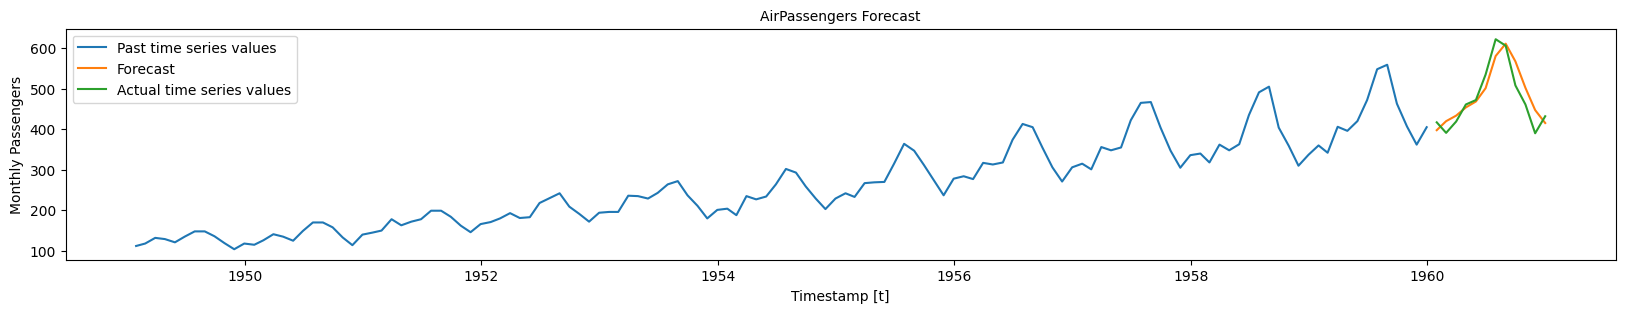

In [ ]:
Y_train_df.set_index('ds',inplace =True)
#y_hat.set_index('ds',inplace =True)
Y_test_df.set_index('ds',inplace =True)

plt.figure(figsize=(20, 3))

y_past = Y_train_df["y"]
y_pred = y_hat[['GRU']]
y_test = Y_test_df["y"]

plt.plot(y_past, label="Past time series values")
plt.plot(y_pred, label="Forecast")
plt.plot(y_test, label="Actual time series values")
plt.title('AirPassengers Forecast', fontsize=10)
plt.ylabel('Monthly Passengers', fontsize=10)
plt.xlabel('Timestamp [t]', fontsize=10)

plt.legend();